In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from influenza_USA.NC_forecasts.utils import get_NC_influenza_data, get_NC_NHSN_data, simulate_baseline_model

## Visualise NC seasons

In [3]:
# settings
start_visualisation_month = 9
end_visualisation_month = 6
seasons = ['2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2023-2024']

# x-axis shen|anigans
months = ["Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun"]
month_ticks = [0, 30, 61, 91, 123, 154, 184, 215, 245, 275]  # Approx days since Sept 1
props = dict(boxstyle='round', facecolor='white', alpha=1)

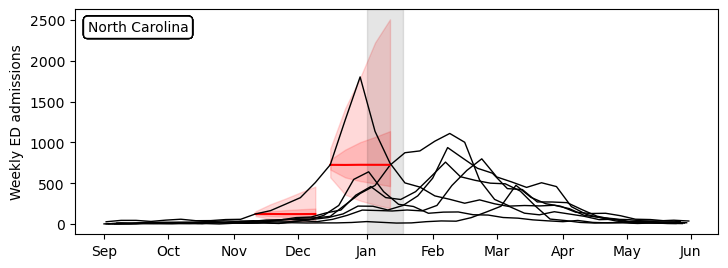

In [4]:
# settings
subtypes = False
highlight = False
highlight_season='2018-2019'
annotation_locations = {
    '2014-2015': {'xy': (115, 550), 'xytext': (60, 1100)},
    '2015-2016': {'xy': (195, 550), 'xytext': (180, 1100)},
    '2016-2017': {'xy': (190, 550), 'xytext': (180, 1100)},
    '2017-2018': {'xy': (170, 1000), 'xytext': (170, 1500)},
    '2018-2019': {'xy': (170, 850), 'xytext': (170, 1200)},
    '2019-2020': {'xy': (170, 580), 'xytext': (170, 1200)},
    '2023-2024': {'xy': (135, 900), 'xytext': (150, 1500)},
}

# make figure
fig,ax=plt.subplots(figsize=(8.3, 11.7/4))
for season in seasons:
    # get data
    df = 7*get_NC_influenza_data(datetime(int(season[0:4]), start_visualisation_month, 1), datetime(int(season[0:4])+1, end_visualisation_month, 1), season)
    
    # TRYOUT BASELINE MODEL >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    if season == '2023-2024':
        # pick a startdate
        n = 100
        sigma = 0.35
        baseline_dates = [df.index[10], df.index[15]]
        for baseline_date in baseline_dates:
            output = simulate_baseline_model(sigma, baseline_date, df.loc[baseline_date, 'H_inc'], n_sim=10000, n_weeks=4)
            # plot it
            dates = output['target_end_date'].unique()
            ax.plot((dates - datetime(int(season[0:4]), start_visualisation_month, 1))/timedelta(days=1), output[output['output_type_id'] == 0.50]['value'].values, color='red')
            ax.fill_between(list((dates - datetime(int(season[0:4]), start_visualisation_month, 1))/timedelta(days=1)),
                                list(output[output['output_type_id'] == 0.025]['value'].values),
                                list(output[output['output_type_id'] == 0.975]['value'].values),
                                color='red', alpha=0.15)
            ax.fill_between(list((dates - datetime(int(season[0:4]), start_visualisation_month, 1))/timedelta(days=1)),
                                list(output[output['output_type_id'] == 0.25]['value'].values),
                                list(output[output['output_type_id'] == 0.75]['value'].values),
                                color='red', alpha=0.15)
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    if ((season == highlight_season) & (highlight == True)):
        # highlight flu season and annotate
        ax.plot((df.index - datetime(int(season[0:4]), start_visualisation_month, 1))/timedelta(days=1), df['H_inc'], color='red', linewidth=2)
        ax.annotate(
            highlight_season, 
            xy = annotation_locations[highlight_season]['xy'], # Coordinates of the point to annotate
            xytext = annotation_locations[highlight_season]['xytext'], # Position of the text
            arrowprops=dict(arrowstyle='-') # Optional arrow properties
        )
        # plot subtypes
        if subtypes == True:
            ax.plot((df.index - datetime(int(season[0:4]), start_visualisation_month, 1))/timedelta(days=1), df['H_inc_A'], linestyle='--', color='black', label='Influenza A')
            ax.plot((df.index - datetime(int(season[0:4]), start_visualisation_month, 1))/timedelta(days=1), df['H_inc_B'], linestyle=':', color='black', label='Influenza B') 
            ax.legend()
    else:
        if highlight == False:
            alpha=1
            # state
            ax.text(0.02, 0.95, 'North Carolina', transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=1))
        else:
            alpha=0.15
        # plot total hospitalisations
        ax.plot((df.index - datetime(int(season[0:4]), start_visualisation_month, 1))/timedelta(days=1), df['H_inc'], color='black', alpha=alpha, linewidth=1)

ax.axvspan(123, 140, alpha=0.1, color='black')

ax.set_ylabel('Weekly ED admissions')
ax.set_xticks(month_ticks)  # Set tick positions
ax.set_xticklabels(months)  # Set month labels
plt.savefig(f'NC-influenza-data_highlight-{highlight}-{highlight_season}_subtypes-{subtypes}.pdf')
plt.show()
plt.close()

## Compare NHSN and NC Detect data on 2023-2024

In [10]:
# get data
NC_detect = get_NC_influenza_data(datetime(2023, 11, 15), datetime(2024, 4, 15), '2023-2024')['H_inc']*7
NHSN = get_NC_NHSN_data(datetime(2023, 11, 15), datetime(2024, 4, 15))
# Function to compute cross-correlation for all lags
def cross_correlation(series1, series2):
    n = len(series1)
    lags = np.arange(-n + 1, n)
    corr = np.correlate(series1 - np.mean(series1), series2 - np.mean(series2), mode='full')
    corr /= (np.std(series1) * np.std(series2) * n)  # Normalize
    return lags, corr
# Compute cross-correlation
lags, correlations = cross_correlation(NHSN, NC_detect)

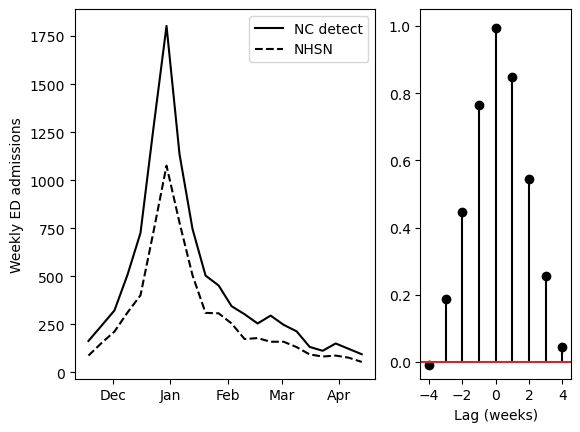

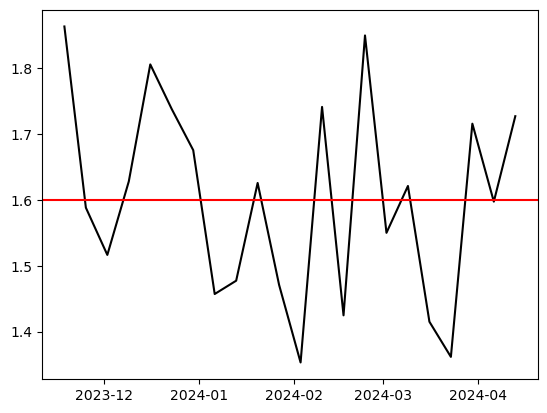

In [13]:
fig,ax=plt.subplots(nrows=1, ncols=2, width_ratios=[2,1])
# Plot the data
ax[0].plot(NC_detect, label='NC detect', color='black')
ax[0].plot(NHSN, label='NHSN', color='black', linestyle='--')
ax[0].legend()
ax[0].set_ylabel('Weekly ED admissions')
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
fmt = mdates.DateFormatter('%b')
ax[0].xaxis.set_major_formatter(fmt)

# Plot the cross correlation
ax[1].stem(lags, correlations, linefmt='black')
ax[1].set_xlim([-4.5,4.5])
ax[1].set_ylim([-0.05,1.05])
ax[1].set_xlabel("Lag (weeks)")
ax[1].set_xticks([-4, -2, 0, 2, 4])
plt.show()
plt.close()

fig,ax=plt.subplots()
ax.plot(NC_detect/NHSN, color='black')
ax.axhline((NC_detect/NHSN).mean(), color='red')
plt.show()
plt.close()